# Chapter 8 - Tree-based Methods
Source: https://github.com/JWarmenhoven/ISLR-python


SK-Learn Documentation: https://scikit-learn.org/dev/modules/tree.html


- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)
- [Lab: 8.3.2 Fitting Regression Trees](#8.3.2-Fitting-Regression-Trees)
- [Lab: 8.3.3 Bagging and Random Forests](#8.3.3-Bagging-and-Random-Forests)
- [Lab: 8.3.4 Boosting](#8.3.4-Boosting)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.1.1 Regression Trees

Hitters.csv contains Major League Baseball Data from the 1986 and 1987 seasons.

Variable | Description
----------- | -----------
AtBat | Number of times at bat in 1986
Hits | Number of hits in 1986
HmRun | Number of home runs in 1986
Runs |Number of runs in 1986
RBI |Number of runs batted in in 1986
Walks |Number of walks in 1986
Years |Number of years in the major leagues
CAtBat |Number of times at bat during his career
CHits |Number of hits during his career
CHmRun |Number of home runs during his career
CRuns |Number of runs during his career
CRBI |Number of runs batted in during his career
CWalks |Number of walks during his career
League |A factor with levels A and N indicating player's league at the end of 1986
Division |A factor with levels E and W indicating player's division at the end of 1986
PutOuts |Number of put outs in 1986
Assists |Number of assists in 1986
Errors |Number of errors in 1986
Salary |1987 annual salary on opening day in thousands of dollars
NewLeague |A factor with levels A and N indicating player's league at the beginning of 1987

In [3]:
# Tests to see if we are running in the Google Colaboratory environment
# If so, use an https URL to access the data.  Otherwise, load via the file path
try:
  import google.colab
  data_file_prefix = "https://raw.githubusercontent.com/slankas/DataScienceNotebooks/master/ModelingPart1/"
  import plotly.io as pio
  pio.renderers.default = 'colab'
except:
  data_file_prefix = ""

In [4]:
df = pd.read_csv(data_file_prefix+'data/Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  263 non-null    object 
 1   AtBat       263 non-null    int64  
 2   Hits        263 non-null    int64  
 3   HmRun       263 non-null    int64  
 4   Runs        263 non-null    int64  
 5   RBI         263 non-null    int64  
 6   Walks       263 non-null    int64  
 7   Years       263 non-null    int64  
 8   CAtBat      263 non-null    int64  
 9   CHits       263 non-null    int64  
 10  CHmRun      263 non-null    int64  
 11  CRuns       263 non-null    int64  
 12  CRBI        263 non-null    int64  
 13  CWalks      263 non-null    int64  
 14  League      263 non-null    object 
 15  Division    263 non-null    object 
 16  PutOuts     263 non-null    int64  
 17  Assists     263 non-null    int64  
 18  Errors      263 non-null    int64  
 19  Salary      263 non-null    f

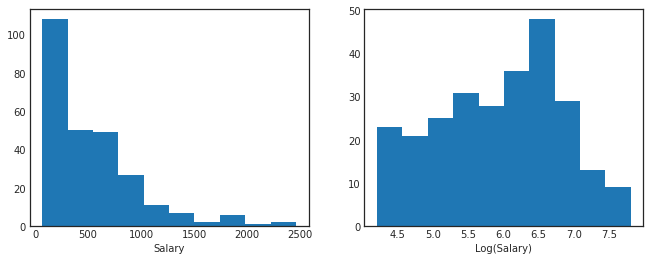

In [5]:
X = df[['Years', 'Hits']].to_numpy ()
y = np.log(df.Salary.to_numpy ())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary.to_numpy ())
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

In [6]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

### Figure 8.1

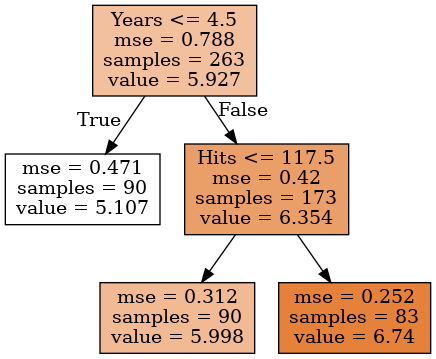

In [7]:
graph, = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())

###  Figure 8.2

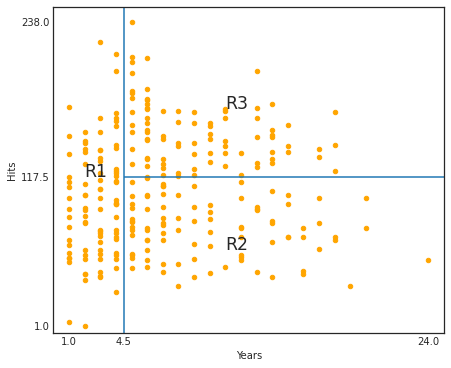

In [8]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

### Pruning
This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree.

One possible implementation would be to loop through creating trees with different numbers of "max_leaf_nodes" and then use the result with the smallest error.
    

### 8.1.2 Classification Trees

Dataset from https://www.statlearning.com/s/Heart.csv

In [9]:
df2 = pd.read_csv(data_file_prefix+'data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [10]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [11]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [12]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(max_features=3, max_leaf_nodes=6)

In [13]:
clf.score(X2,y2)

0.7946127946127947

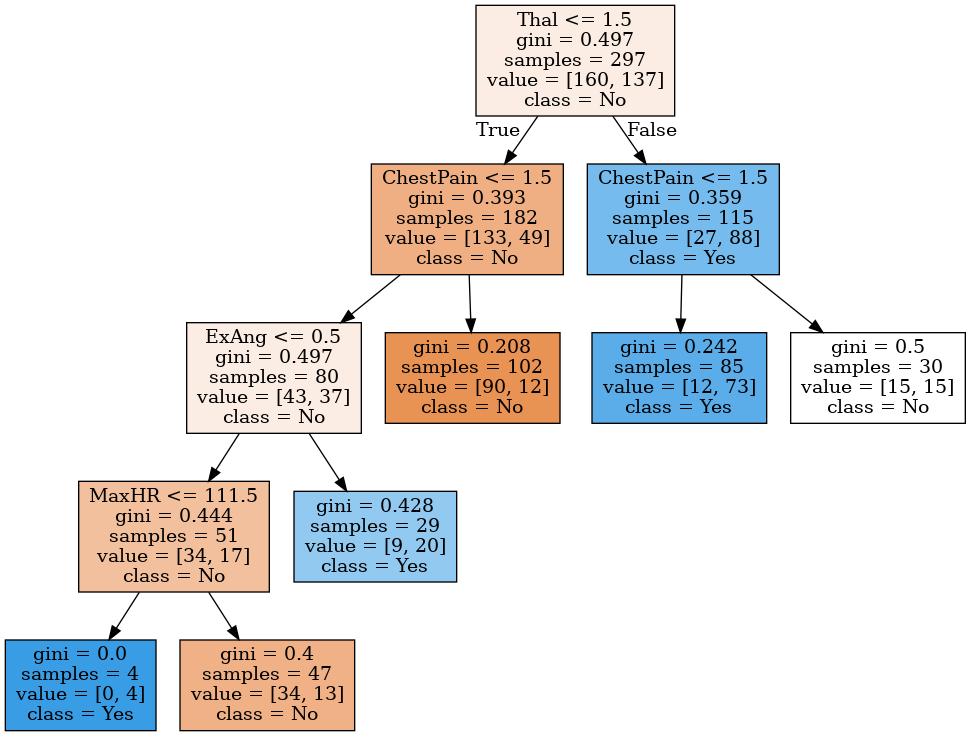

In [14]:
graph2, = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
Image(graph2.create_png())

## Lab

### 8.3.1 Fitting Classification Trees
Predict if child car seat sales will be greater than 8,000 units at a particular store

Car Seats is  simulated data set containing sales of child car seats at 400 different stores, with 11 variables

Variable | Description
:--- | :---
Sales | Unit sales (in thousands) at each location
CompPrice | Price charged by competitor at each location
Income | Community income level (in thousands of dollars)
Advertising | Local advertising budget for company at each location (in thousands of dollars)
Population | Population size in region (in thousands)
Price | Price company charges for car seats at each site
ShelveLoc | A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
Age | Average age of the local population
Education | Education level at each location
Urban | A factor with levels No and Yes to indicate whether the store is in an urban or rural location
US | A factor with levels No and Yes to indicate whether the store is in the US or not


In [15]:
df3 = pd.read_csv(data_file_prefix + 'data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [16]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [17]:
df3.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In [18]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

### Danger!!!  As an example, training and testing on the entire data set

In [19]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=6)

In [20]:
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93       236
           1       0.98      0.82      0.89       164

    accuracy                           0.92       400
   macro avg       0.93      0.90      0.91       400
weighted avg       0.92      0.92      0.92       400



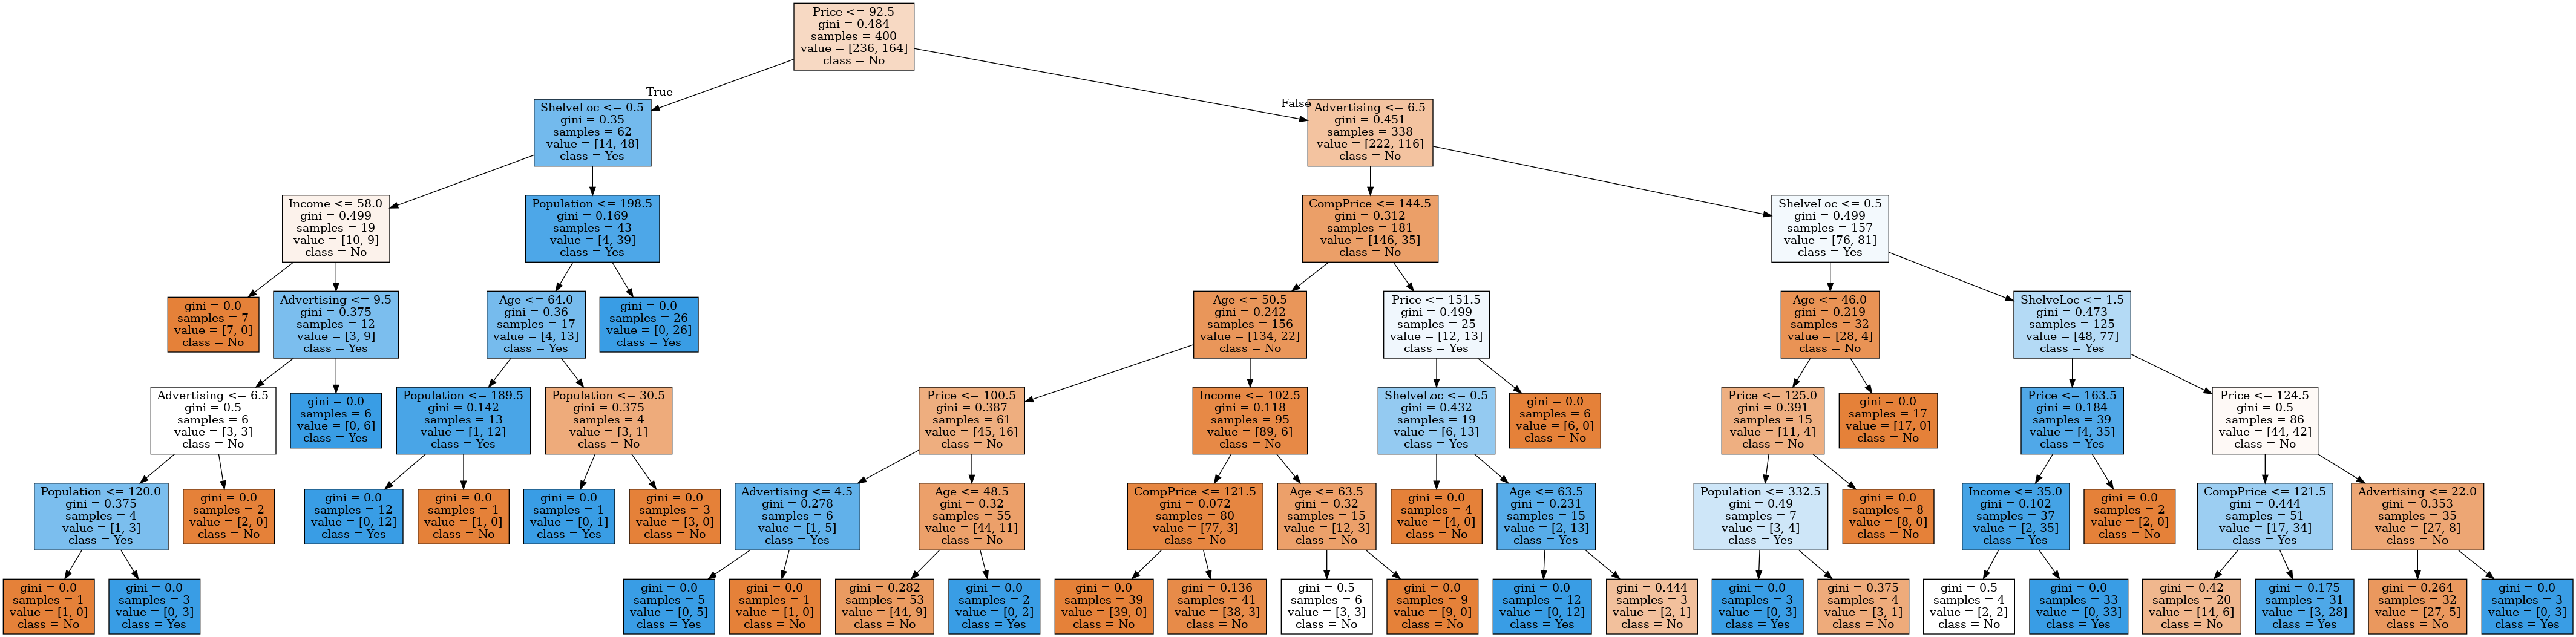

In [21]:
graph3, = print_tree(clf, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

### now, train on the training set, test on the test set

In [22]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [23]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,No,Yes
Predicted,,
No,100,32
Yes,18,50


In [24]:
# Precision of the model using test data is 74%
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       118
           1       0.74      0.61      0.67        82

    accuracy                           0.75       200
   macro avg       0.75      0.73      0.73       200
weighted avg       0.75      0.75      0.75       200



### 8.3.2 Fitting Regression Trees

Housing values in the Boston suburbs.  This data set contains 506 rows and 14 columns/variables:

Variable | Description
----------- | ---------
crim | per capita crime rate by town.
zn | proportion of residential land zoned for lots over 25,000 sq.ft.
indus | proportion of non-retail business acres per town.
chas | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
nox| nitrogen oxides concentration (parts per 10 million).
rm | average number of rooms per dwelling.
age | proportion of owner-occupied units built prior to 1940.
dis | weighted mean of distances to five Boston employment centres.
rad | index of accessibility to radial highways.
tax | full-value property-tax rate per \$10,000.
ptratio | pupil-teacher ratio by town.
black | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
lstat | lower status of the population (percent).
medv | median value of owner-occupied homes in \$1000s.

Data Source: https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/Boston.html

In [25]:
boston_df = pd.read_csv(data_file_prefix + 'data/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [26]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [27]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)

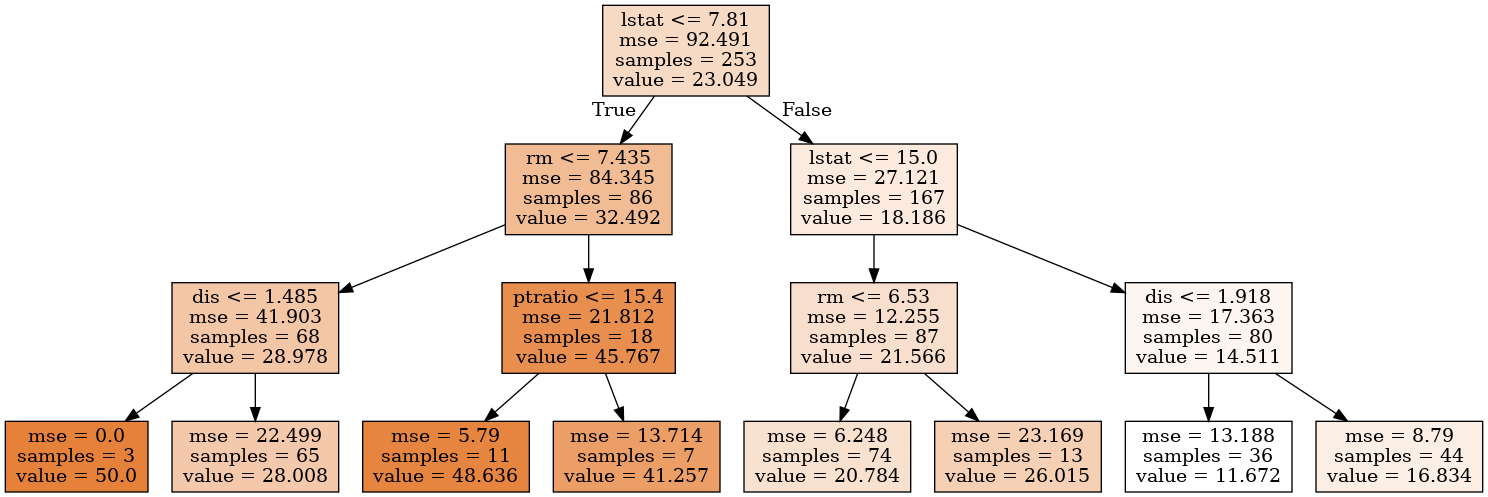

In [28]:
graph, = print_tree(regr2, features=X.columns)
Image(graph.create_png())

Text(0, 0.5, 'y_test')

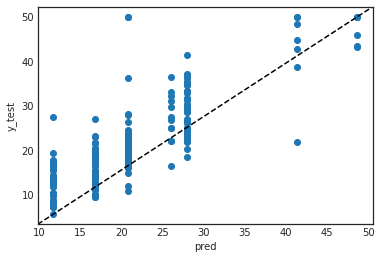

In [29]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [30]:
mean_squared_error(y_test, pred)

26.023230850097445

### 8.3.3 Bagging and Random Forests

In [31]:
# There are 13 features in the dataset
X.shape

(506, 13)

In [32]:
# Bagging: using all features
regr1 = RandomForestRegressor(max_features=13, random_state=1)
regr1.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

Text(0, 0.5, 'y_test')

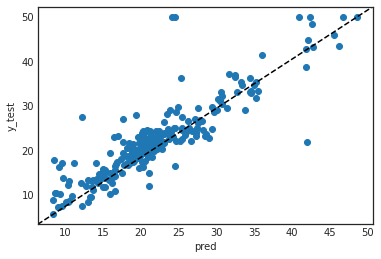

In [33]:
pred = regr1.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [34]:
mean_squared_error(y_test, pred)

16.17512869960475

In [35]:
# Random forests: using 6 features
regr2 = RandomForestRegressor(max_features=6, random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(max_features=6, random_state=1)

In [36]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

15.82350045849802

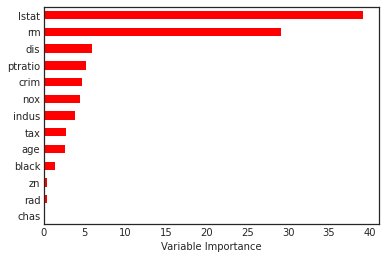

In [37]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## Viewing an individual tree in the forest

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       118
           1       0.83      0.61      0.70        82

    accuracy                           0.79       200
   macro avg       0.80      0.76      0.77       200
weighted avg       0.80      0.79      0.78       200



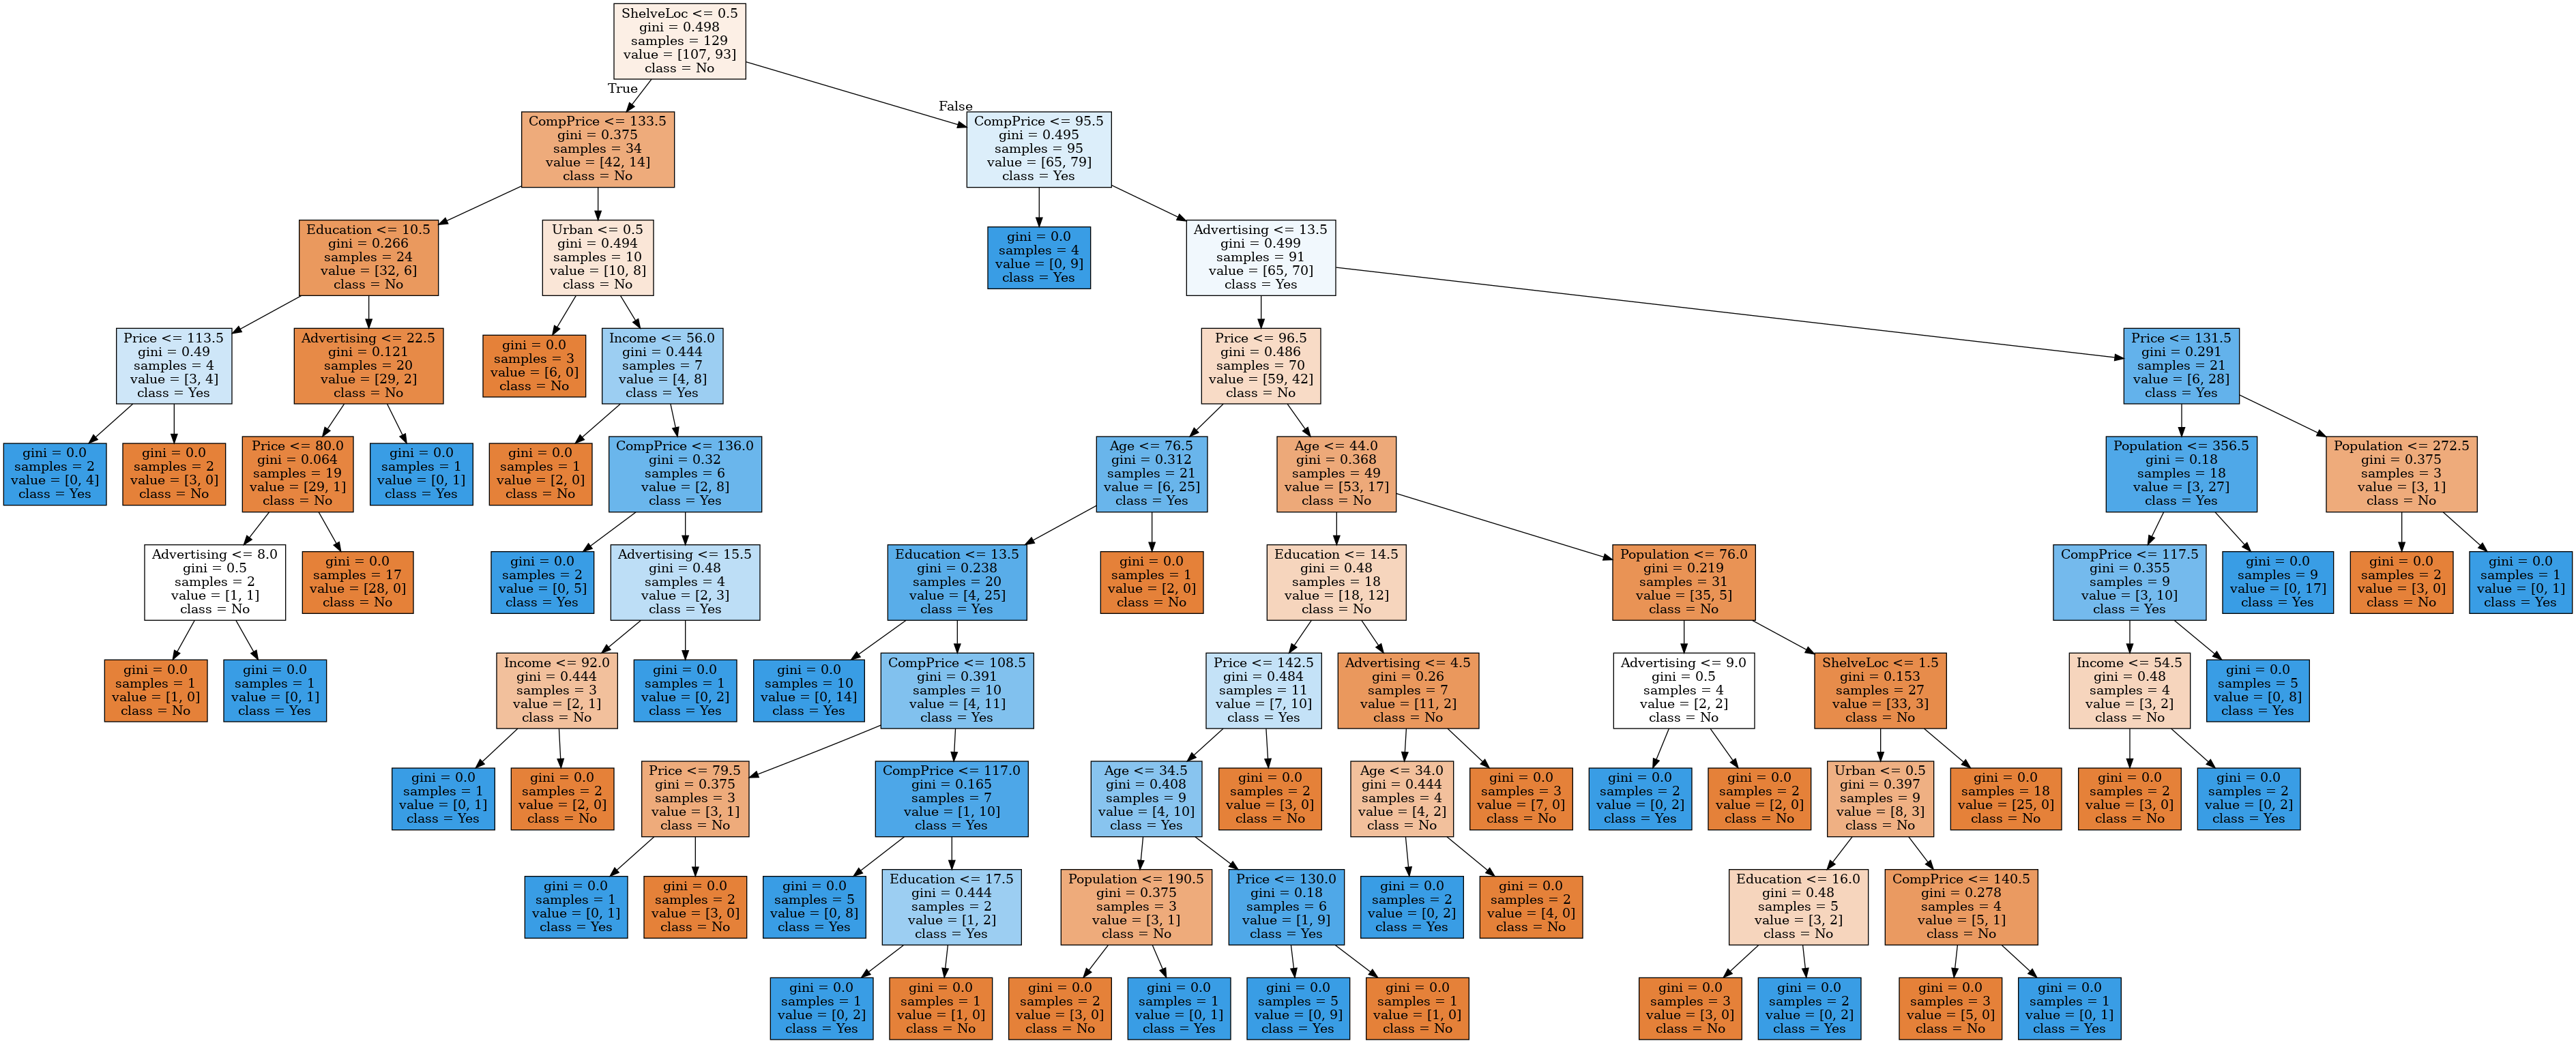

In [38]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))
# How did this performance change versus using just a a single decision tree?

## Show the 6th tree
estimator = model.estimators_[5]
graph, = print_tree(estimator, features=X.columns, class_names=['No', 'Yes'])
Image(graph.create_png())

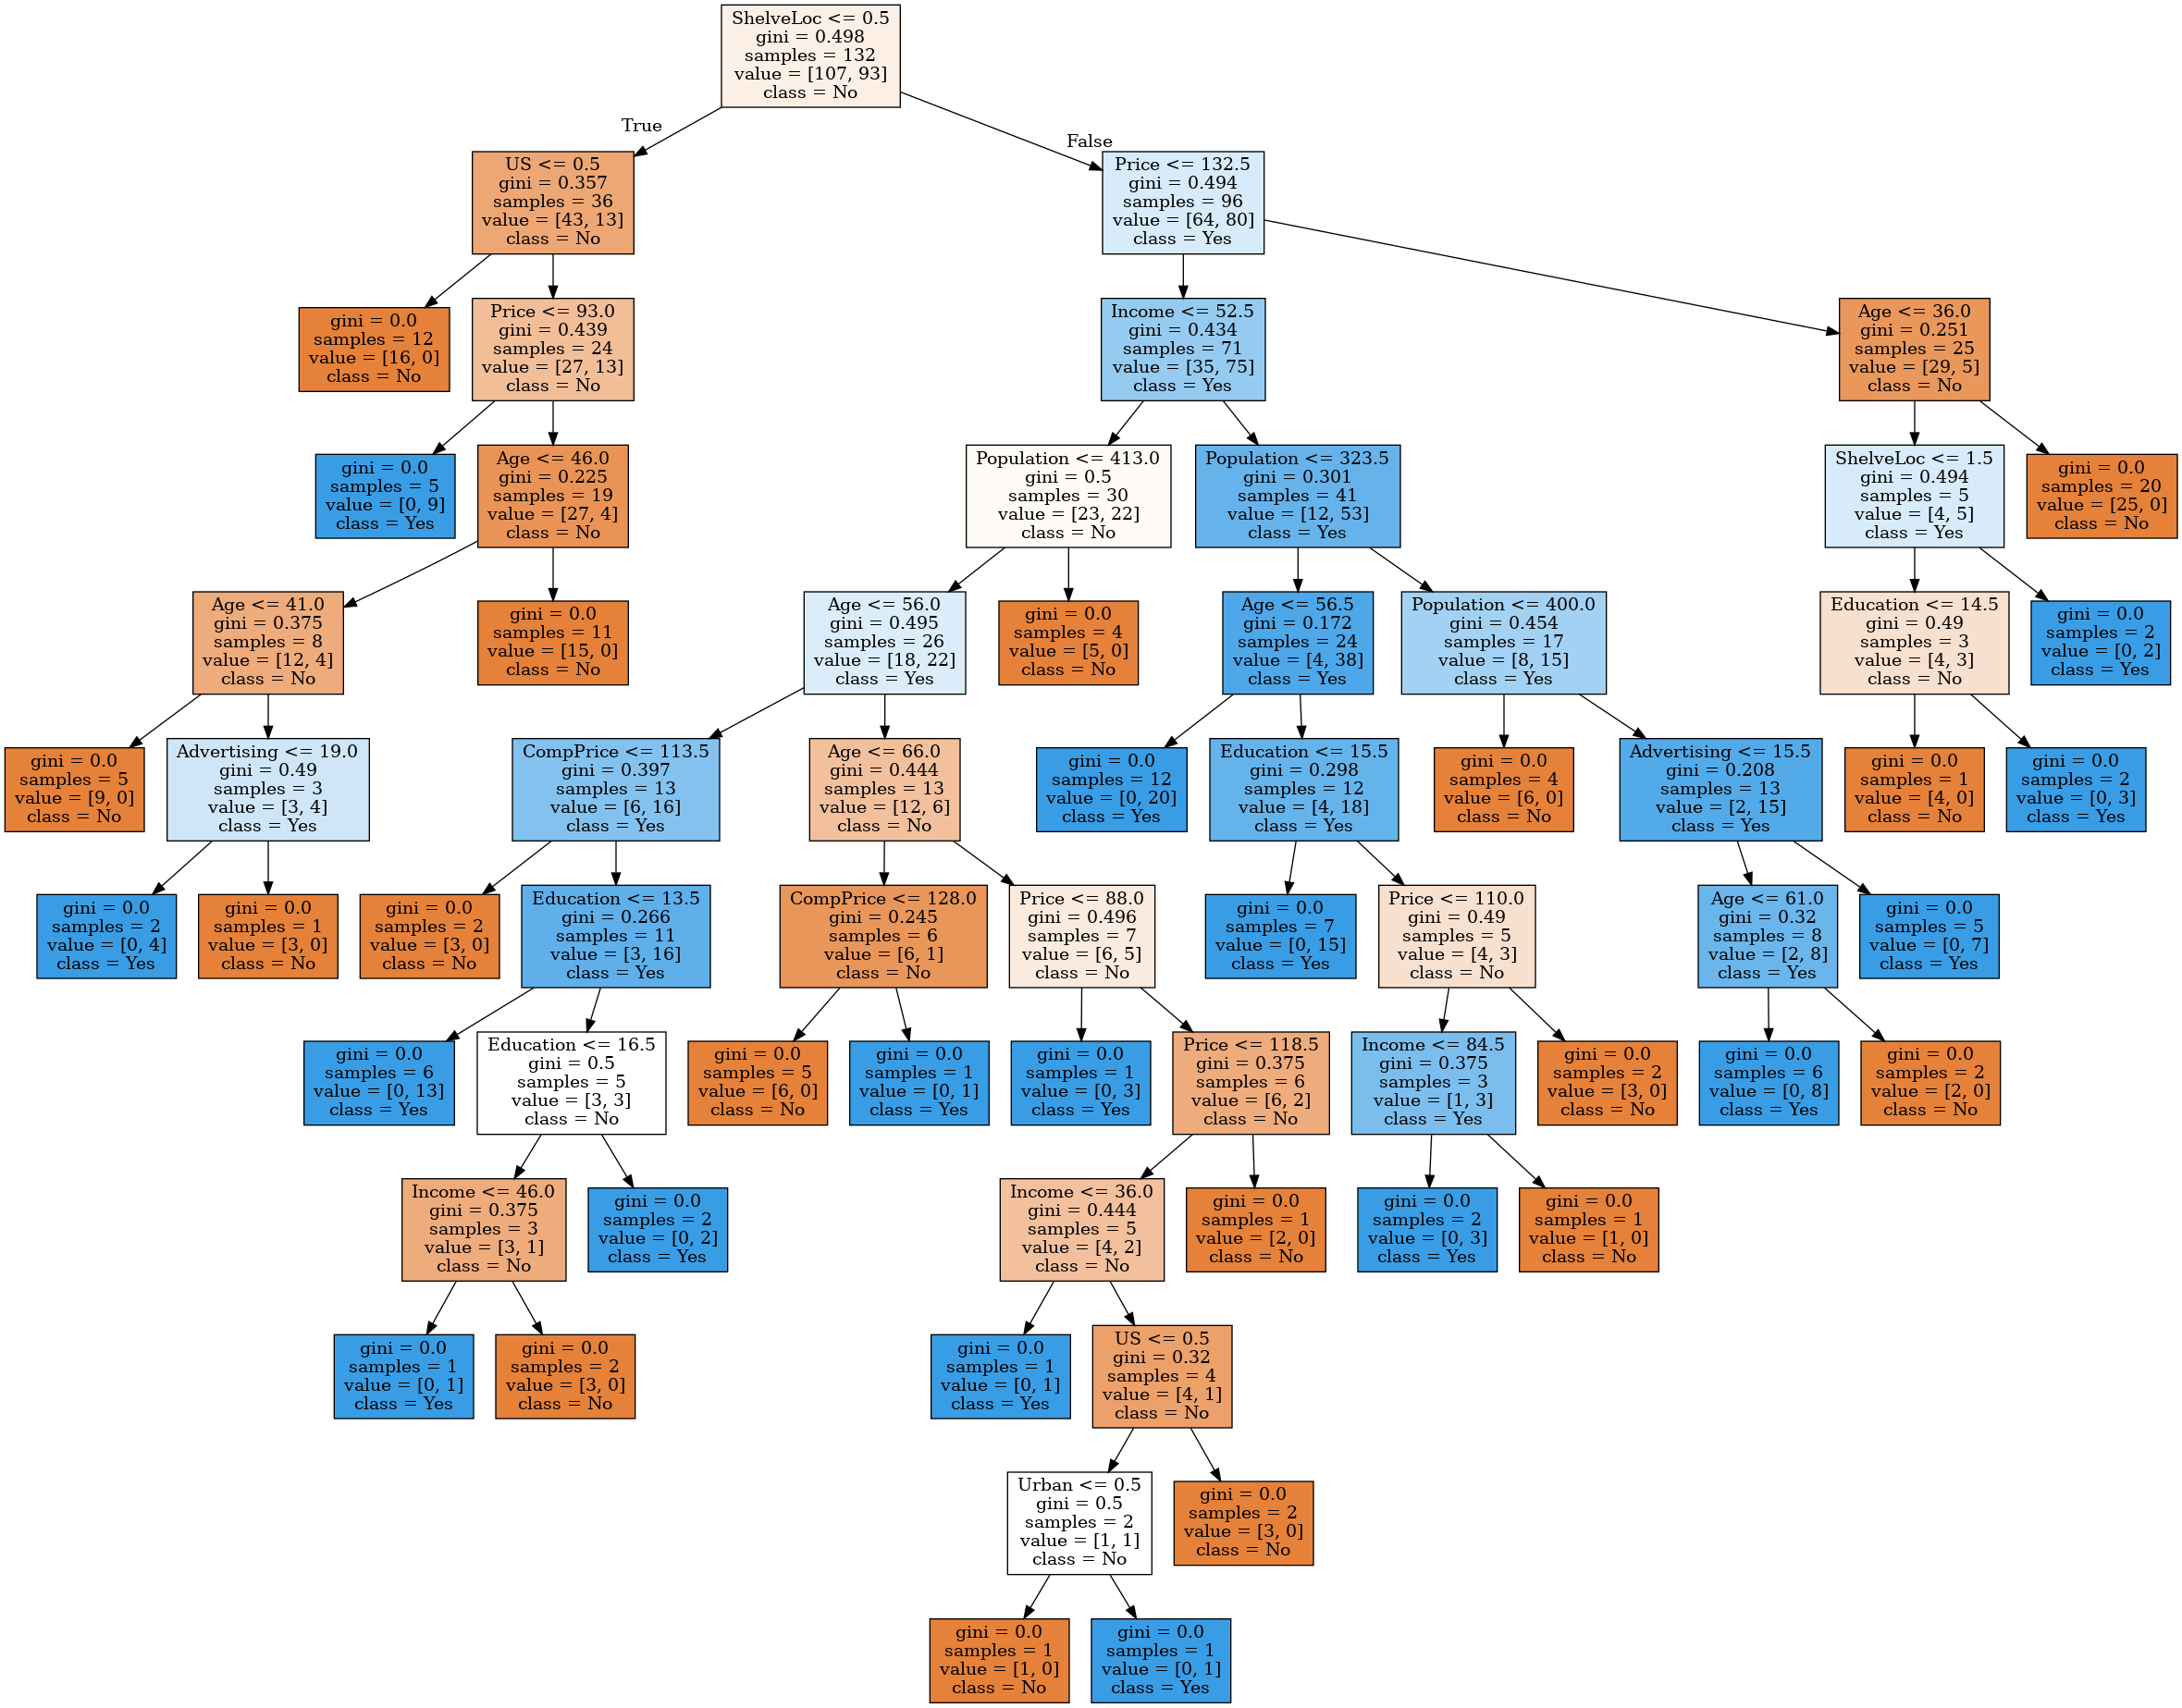

In [39]:
## Show the last tree
estimator = model.estimators_[99]
graph, = print_tree(estimator, features=X.columns, class_names=['No', 'Yes'])
Image(graph.create_png())

### 8.3.4 Boosting

In [40]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=1)

zn          0.013059
chas        0.121257
rad         0.153199
black       0.460309
indus       0.576559
nox         0.731767
age         0.922677
tax         1.098078
crim        2.799589
ptratio     4.370389
dis         5.896297
rm         27.934202
lstat      54.922618
dtype: float64


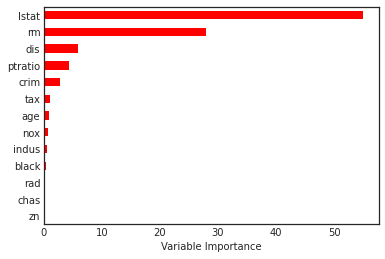

In [41]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [42]:
mean_squared_error(y_test, regr.predict(X_test))

15.592155779633027